# Task 1: Class Imbalance Problem - EDA

In [1]:
import pandas as pd

# Load the train_data CSV file
train_data_path = 'Ecommerce/train_data.csv'
train_data = pd.read_csv(train_data_path)

# Display positive, negative, and neutral reviews
print("Positive Review Example:")
print(train_data[train_data['sentiment'] == 'Positive']['reviews.text'].iloc[0])
print("Negative Review Example:")
print(train_data[train_data['sentiment'] == 'Negative']['reviews.text'].iloc[0])
print("Neutral Review Example:")
print(train_data[train_data['sentiment'] == 'Neutral']['reviews.text'].iloc[0])

# Check class count for each sentiment
class_counts = train_data['sentiment'].value_counts()
print("Class Count:")
print(class_counts)


Positive Review Example:
Purchased on Black FridayPros - Great Price (even off sale)Very powerful and fast with quad core processors Amazing soundWell builtCons -Amazon ads, Amazon need this to subsidize the tablet and will remove the adds if you pay them $15.Inability to access other apps except the ones from Amazon. There is a way which I was able to accomplish to add the Google Play storeNet this is a great tablet for the money
Negative Review Example:
was cheap, can not run chrome stuff, returned to store.
Neutral Review Example:
Just an average Alexa option. Does show a few things on screen but still limited.
Class Count:
Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64


# Task 2: Convert Reviews to Tf-Idf Scores

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert reviews.text to Tf-Idf scores
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(train_data['reviews.text'])


# Task 3: Run Multinomial Naive Bayes Classifier

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)
tfidf_val = tfidf_vectorizer.transform(val_df['reviews.text'])

# Train the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, train_data['sentiment'])

# Predict on the validation set
nb_pred = nb_classifier.predict(tfidf_val)

# Set zero_division=0 to handle the warning
zero_division_value = 0

# Evaluate the model
print("Multinomial Naive Bayes Classifier Report:")
print(classification_report(val_df['sentiment'], nb_pred, zero_division=zero_division_value))


Multinomial Naive Bayes Classifier Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        13
     Neutral       0.00      0.00      0.00        36
    Positive       0.94      1.00      0.97       751

    accuracy                           0.94       800
   macro avg       0.31      0.33      0.32       800
weighted avg       0.88      0.94      0.91       800



# Task 4: Tackling Class Imbalance Problem - Oversampling or Undersampling

In [4]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Oversampling using RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
tfidf_train_over, train_over_sentiment = over_sampler.fit_resample(tfidf_train, train_data['sentiment'])

# Undersampling using RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)
tfidf_train_under, train_under_sentiment = under_sampler.fit_resample(tfidf_train, train_data['sentiment'])


# Task 5: Tree-Based Classifiers (Random Forest and XGBoost)

### One hot encode Target Variable

In [5]:
# Perform label encoding using pd.get_dummies on the target variable
encoded_sentiment_train = pd.get_dummies(train_data['sentiment'])

# Extract the TF-IDF features for the training data
tfidf_train = tfidf_vectorizer.transform(train_data['reviews.text'])

In [6]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report



# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(tfidf_train, encoded_sentiment_train)

# Train the XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(tfidf_train, encoded_sentiment_train)

# Make predictions using the Random Forest Classifier
rf_pred = rf_classifier.predict(tfidf_train)

# Make predictions using the XGBoost Classifier
xgb_pred = xgb_classifier.predict(tfidf_train)

# Evaluate Random Forest Classifier
print("Random Forest Classifier Report:")
print(classification_report(encoded_sentiment_train, rf_pred, zero_division=zero_division_value))

# Evaluate XGBoost Classifier
print("XGBoost Classifier Report:")
print(classification_report(encoded_sentiment_train, xgb_pred, zero_division=zero_division_value))


Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      0.99      1.00       158
           2       1.00      1.00      1.00      3749

   micro avg       1.00      1.00      1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000
 samples avg       1.00      1.00      1.00      4000

XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      0.96      0.98       158
           2       1.00      1.00      1.00      3749

   micro avg       1.00      1.00      1.00      4000
   macro avg       1.00      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000
 samples avg       1.00      1.00      1.00      4000



# Task 6: Model Evaluation with Sentiment Score Feature

In [7]:
from textblob import TextBlob

def sentiment_scoring_function(text):
    return TextBlob(text).sentiment.polarity


'from textblob import TextBlob\n\ndef sentiment_scoring_function(text):\n    return TextBlob(text).sentiment.polarity'

In [8]:
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler

# Engineer a sentiment score feature based on the reviews for both training and validation data
train_data['sentiment_score'] = train_data['reviews.text'].apply(sentiment_scoring_function)
val_df['sentiment_score'] = val_df['reviews.text'].apply(sentiment_scoring_function)

# Scale sentiment scores to positive scale for MultinomialNB
scaler = MinMaxScaler(feature_range=(0, 1))
train_data['sentiment_score_scaled'] = scaler.fit_transform(train_data[['sentiment_score']])
val_df['sentiment_score_scaled'] = scaler.transform(val_df[['sentiment_score']])

# Convert reviews to Tf-Idf scores
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(train_data['reviews.text'])
tfidf_val = tfidf_vectorizer.transform(val_df['reviews.text'])

# Convert sentiment scores into sparse format
sparse_sentiment_train_scaled = csr_matrix(train_data['sentiment_score_scaled']).T
sparse_sentiment_val_scaled = csr_matrix(val_df['sentiment_score_scaled']).T

# Combine original Tf-Idf scores with scaled sentiment score
tfidf_train_combined = hstack((tfidf_train, sparse_sentiment_train_scaled))
tfidf_val_combined = hstack((tfidf_val, sparse_sentiment_val_scaled))

# Convert categorical target to numerical form
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_data['sentiment'] = le.fit_transform(train_data['sentiment'])
val_df['sentiment'] = le.transform(val_df['sentiment'])


# Train and evaluate classifiers using combined feature representation
nb_classifier_combined = MultinomialNB()
nb_classifier_combined.fit(tfidf_train_combined, train_data['sentiment'])
nb_pred_combined = nb_classifier_combined.predict(tfidf_val_combined)

rf_classifier_combined = RandomForestClassifier(random_state=42)
rf_classifier_combined.fit(tfidf_train_combined, train_data['sentiment'])
rf_pred_combined = rf_classifier_combined.predict(tfidf_val_combined)

# Expected: [0 1 2], got ['Negative' 'Neutral' 'Positive']
xgb_classifier_combined = XGBClassifier(random_state=42)
xgb_classifier_combined.fit(tfidf_train_combined, train_data['sentiment'])
xgb_pred_combined = xgb_classifier_combined.predict(tfidf_val_combined)


# Evaluate the models with combined features
print("Multinomial Naive Bayes Classifier (with Sentiment Score) Report:")
print(classification_report(val_df['sentiment'], nb_pred_combined, zero_division=zero_division_value))

print("Random Forest Classifier (with Sentiment Score) Report:")
print(classification_report(val_df['sentiment'], rf_pred_combined, zero_division=zero_division_value))

print("XGBoost Classifier (with Sentiment Score) Report:")
print(classification_report(val_df['sentiment'], xgb_pred_combined, zero_division=zero_division_value))


Multinomial Naive Bayes Classifier (with Sentiment Score) Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.00      0.00      0.00        36
           2       0.94      1.00      0.97       751

    accuracy                           0.94       800
   macro avg       0.31      0.33      0.32       800
weighted avg       0.88      0.94      0.91       800

Random Forest Classifier (with Sentiment Score) Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.97      0.99        36
           2       1.00      1.00      1.00       751

    accuracy                           1.00       800
   macro avg       1.00      0.99      1.00       800
weighted avg       1.00      1.00      1.00       800

XGBoost Classifier (with Sentiment Score) Report:
              precision    recall  f1-score   support

           

# Task 7: Topic Modeling with LDA or NMF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

# Vectorize the text data
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_train = tfidf_vectorizer.fit_transform(train_data['reviews.text'])
tfidf_val = tfidf_vectorizer.transform(val_df['reviews.text'])

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Topic Modeling with Latent Dirichlet Allocation (LDA)
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(tfidf_train)
lda_topics_train = lda_model.transform(tfidf_train)
lda_topics_val = lda_model.transform(tfidf_val)

# Topic Modeling with Non-Negative Matrix Factorization (NMF)
nmf_model = NMF(n_components=5, random_state=42)
nmf_model.fit(tfidf_train)
nmf_topics_train = nmf_model.transform(tfidf_train)
nmf_topics_val = nmf_model.transform(tfidf_val)

# Display the top words for each topic in LDA
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_indices = topic.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_words_indices]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

# Display the top words for each topic in NMF
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_indices = topic.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_words_indices]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")


Topic 1: keeps, does, product, young, amazon, busy, good, love, expectations, tablet
Topic 2: echo, alexa, love, great, music, home, use, easy, sound, product
Topic 3: kindle, tablet, bought, love, gift, great, got, christmas, loves, read
Topic 4: old, year, loves, tablet, bought, grandson, easy, daughter, great, son
Topic 5: tablet, great, use, easy, price, good, kindle, kids, love, bought
Topic 1: love, kindle, kids, books, read, reading, new, games, awesome, size
Topic 2: loves, old, bought, year, daughter, tablet, gift, grandson, son, christmas
Topic 3: great, tablet, price, good, works, product, kids, recommend, apps, buy
Topic 4: easy, use, set, product, setup, fun, recommend, super, lightweight, navigate
Topic 5: echo, alexa, music, home, amazon, plus, like, smart, sound, screen


# Task 8: Visualization of Sentiment Distribution

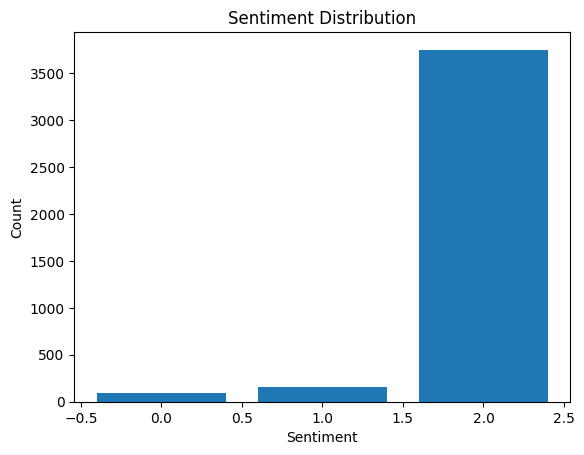

In [10]:
import matplotlib.pyplot as plt

# Plot the distribution of sentiment classes
sentiment_counts = train_data['sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


### Word Frequency Distribution: 
This will give you a sense of the most common words appearing in your reviews. You might need to preprocess your text data (remove stop words, punctuation, etc.) to get meaningful insights.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\templ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


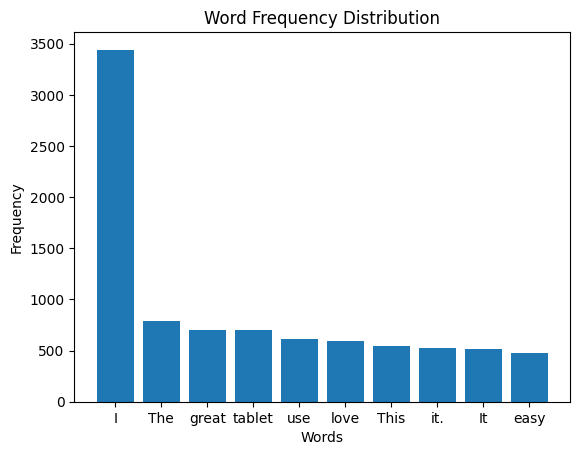

In [11]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

words = ' '.join(train_data['reviews.text']).split()
words = [word for word in words if word not in stopwords]

word_counts = Counter(words)
common_words = word_counts.most_common(10)

words, counts = zip(*common_words)
plt.bar(words, counts)
plt.title('Word Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

### Distribution of Review Lengths: 
This could give you an idea of how long your typical review is.

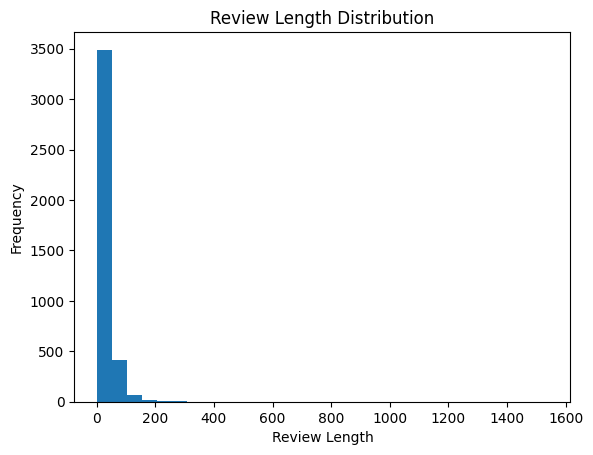

In [12]:
review_lengths = train_data['reviews.text'].apply(lambda x: len(x.split()))
plt.hist(review_lengths, bins=30)
plt.title('Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()


### Distribution of Reviews by Primary Categories: 
This will give you an understanding of which categories have the most reviews.

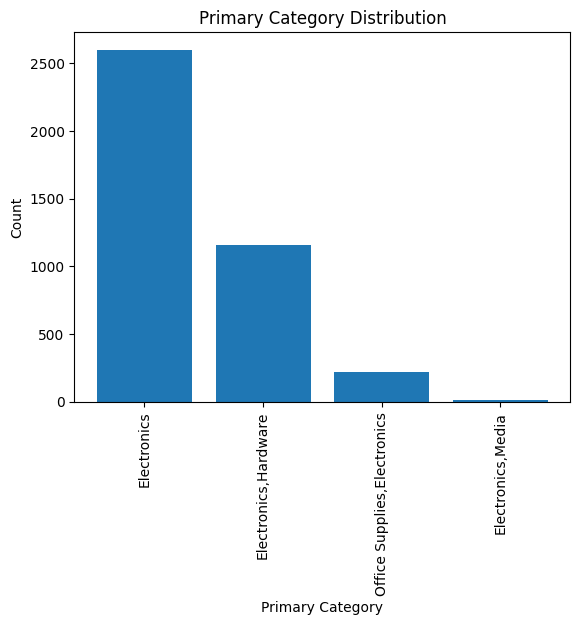

In [13]:
primary_category_counts = train_data['primaryCategories'].value_counts()
plt.bar(primary_category_counts.index, primary_category_counts.values)
plt.title('Primary Category Distribution')
plt.xlabel('Primary Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


### Boxplot of Review Lengths by Sentiment: 
This can provide some insights into whether sentiment is related to review length.

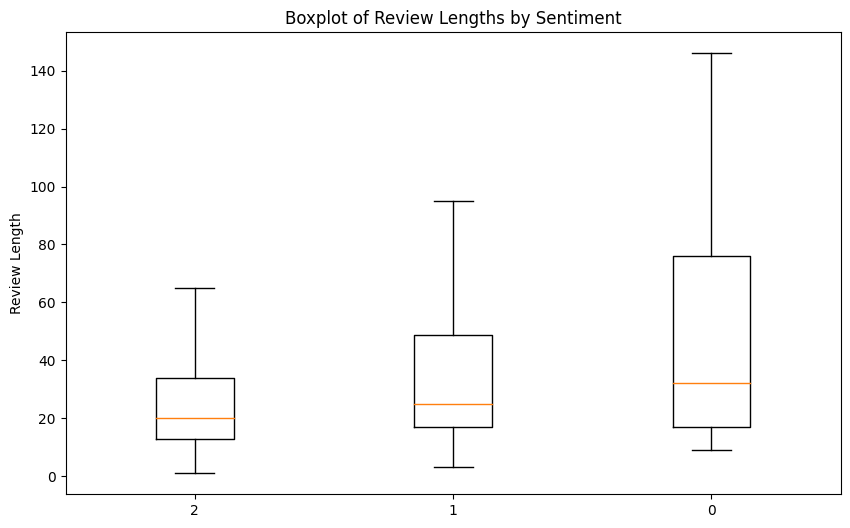

In [14]:
train_data['review_length'] = train_data['reviews.text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.boxplot([train_data.loc[train_data['sentiment']==sentiment, 'review_length'] for sentiment in sentiment_counts.index], 
            labels=sentiment_counts.index, showfliers=False)
plt.title('Boxplot of Review Lengths by Sentiment')
plt.ylabel('Review Length')
plt.show()